In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import scipy
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
sns.set_style('whitegrid')

Loading the data



In [ ]:
train_features = pd.read_csv('train_features.csv')
test_features = pd.read_csv('test_features.csv')
train_salaries = pd.read_csv('train_salaries.csv')

'\nAs we can see the salaries form a gaussian distribution. \n'

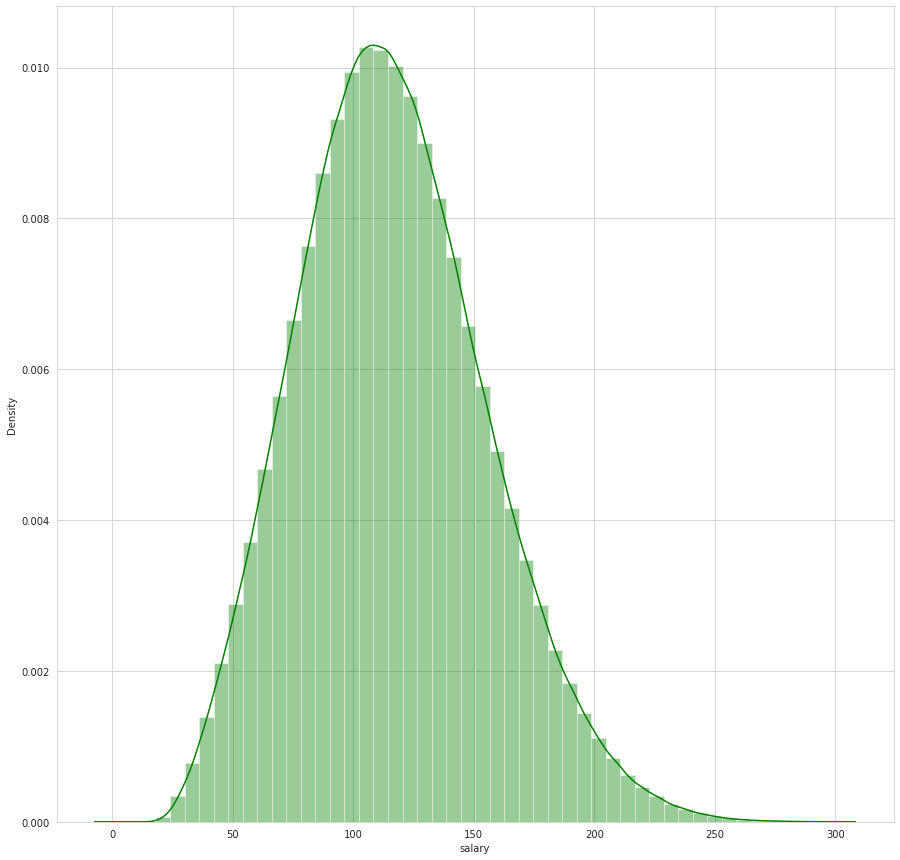

In [ ]:
plt.figure(figsize=(15, 15))
sns.distplot(train_salaries['salary'], hist=True, color='g')

def gaussianPlot(ytrue, yhat, title=None):
  plt.figure(figsize=(12, 12))
  sns.distplot(ytrue, hist=False, color='g', label='True Values')
  sns.distplot(yhat, hist=False, color='r', label='Predicted values')
  plt.title(title)


'''
As we can see the salaries form a gaussian distribution. 
'''

In [ ]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [ ]:
# train_data = pd.merge(train_features, train_salaries, on='jobId')
#get the name of the columns
columns = train_features.columns

In [ ]:
#check for the categorical labels
categorical_feature_names = ['companyId', 'jobType', 'degree', 'major', 'industry']
int_feature_names = ['yearsExperience', 'milesFromMetropolis']


In [ ]:
#check for nan in the dataset. Clean the data if there are nan
print(train_features.isnull().sum())

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64


In [ ]:
#check for nan in the dataset. Clean the data if there are nan
print(test_features.isnull().sum())

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64


In [ ]:
#check for nan in the dataset. Clean the data if there are nan
print(train_salaries.isnull().sum())

jobId     0
salary    0
dtype: int64


As there are no missing values, we can start working with data for the model.

In [ ]:
#combine train features with target salaries
train_data = pd.merge(train_features, train_salaries, on='jobId')

In [ ]:
#check for the negative values in the yearsExperience, and milesFromMetropolis column
invalid_YOE = train_data[train_data['yearsExperience'] < 0]
print(len(invalid_YOE))

invalid_salaries = train_data[train_data['salary'] <= 0]
print(len(invalid_salaries))

invalid_miles = train_data[train_data['milesFromMetropolis'] < 0]

#we can drop the jobID as it is the unique column in the dataset
#It wont be useful for the prediction of salaries, so we can drop it
train_data_clean = train_data.drop_duplicates(subset = ['jobId', 'companyId'])
train_data_clean = train_data.drop(['jobId', 'companyId'], axis = 1)


train_data_clean = train_data_clean[train_data_clean['milesFromMetropolis'] >= 0]
train_data_clean = train_data_clean[train_data_clean['yearsExperience'] >= 0]
train_data_clean = train_data_clean[train_data_clean['salary'] > 0]

#we removed those five invalid rows

0
5


In [ ]:
train_data_clean

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
...,...,...,...,...,...,...,...
999995,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,CFO,MASTERS,NONE,HEALTH,6,5,149


We always have to keep an eye on the outliers as they would introduce too much variance to the dataset

Finding the outliers in train salaries. We will use visualization methods to figure out the visualization errors. 

*Outlier: Observation point that is distant from other observations*

**Box plot**

1. Univariate analysis
2. IQR score : Inter Quartile Range
 

Outliers using univariate analysis :  866


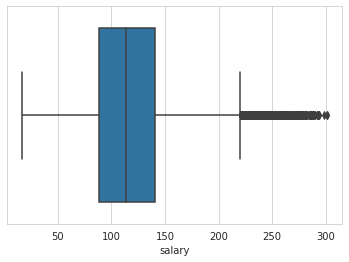

In [ ]:
sns.boxplot(x=train_data_clean['salary'])
#this is uni-variate outlier i.e we have used salary column to detect the outlier.
univariate_outliers = train_data_clean[train_data_clean['salary'] >= 250]
print("Outliers using univariate analysis : ",len(univariate_outliers))

IQR score

IQR = Upper quartile - lower quartile(Q3 - Q1)


**Removing outlier from the dataset using Inter Quartile range**

As the salaries form Gaussian distribution, IQR would be a good outlier detection method




In [ ]:
Q1 = train_data_clean.quantile(0.25)
Q3 = train_data_clean.quantile(0.75)

IQR = Q3 - Q1


'''
Formula for removing outliers based on inter quartile range.
'''
outliers = (train_data_clean < (Q1 - 1.5 * IQR)) | (train_data_clean > (Q3 + 1.5 * IQR)) 


train_data_o_IQR = train_data_clean[~((train_data_clean < (Q1 - 1.5 * IQR)).any(axis=1)]# |(train_data_clean > (Q3 + 1.5 * IQR))).any(axis=1)]

# print("Outliers using Z-score: ", len(train_data_clean) - len(train_data_o_IQR))

print('------------------------------------')
# print("Shape -> Before removing Outliers: {}, After removing Outliers : {}".format(train_data_clean.shape, train_data_o_IQR.shape))

------------------------------------


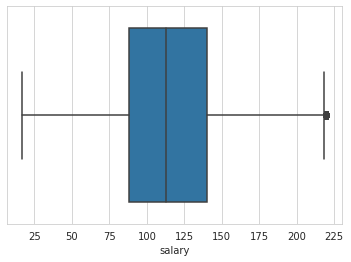

In [ ]:
sns.boxplot(x=train_data_o_IQR['salary'])
#box plot after removing outliers

**Dealing with Categorical variables**

We have make sure how categorical labels can be used for the prediction of salaries.

In [ ]:
train_data_clean.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [ ]:

len(train_data_clean)

999995

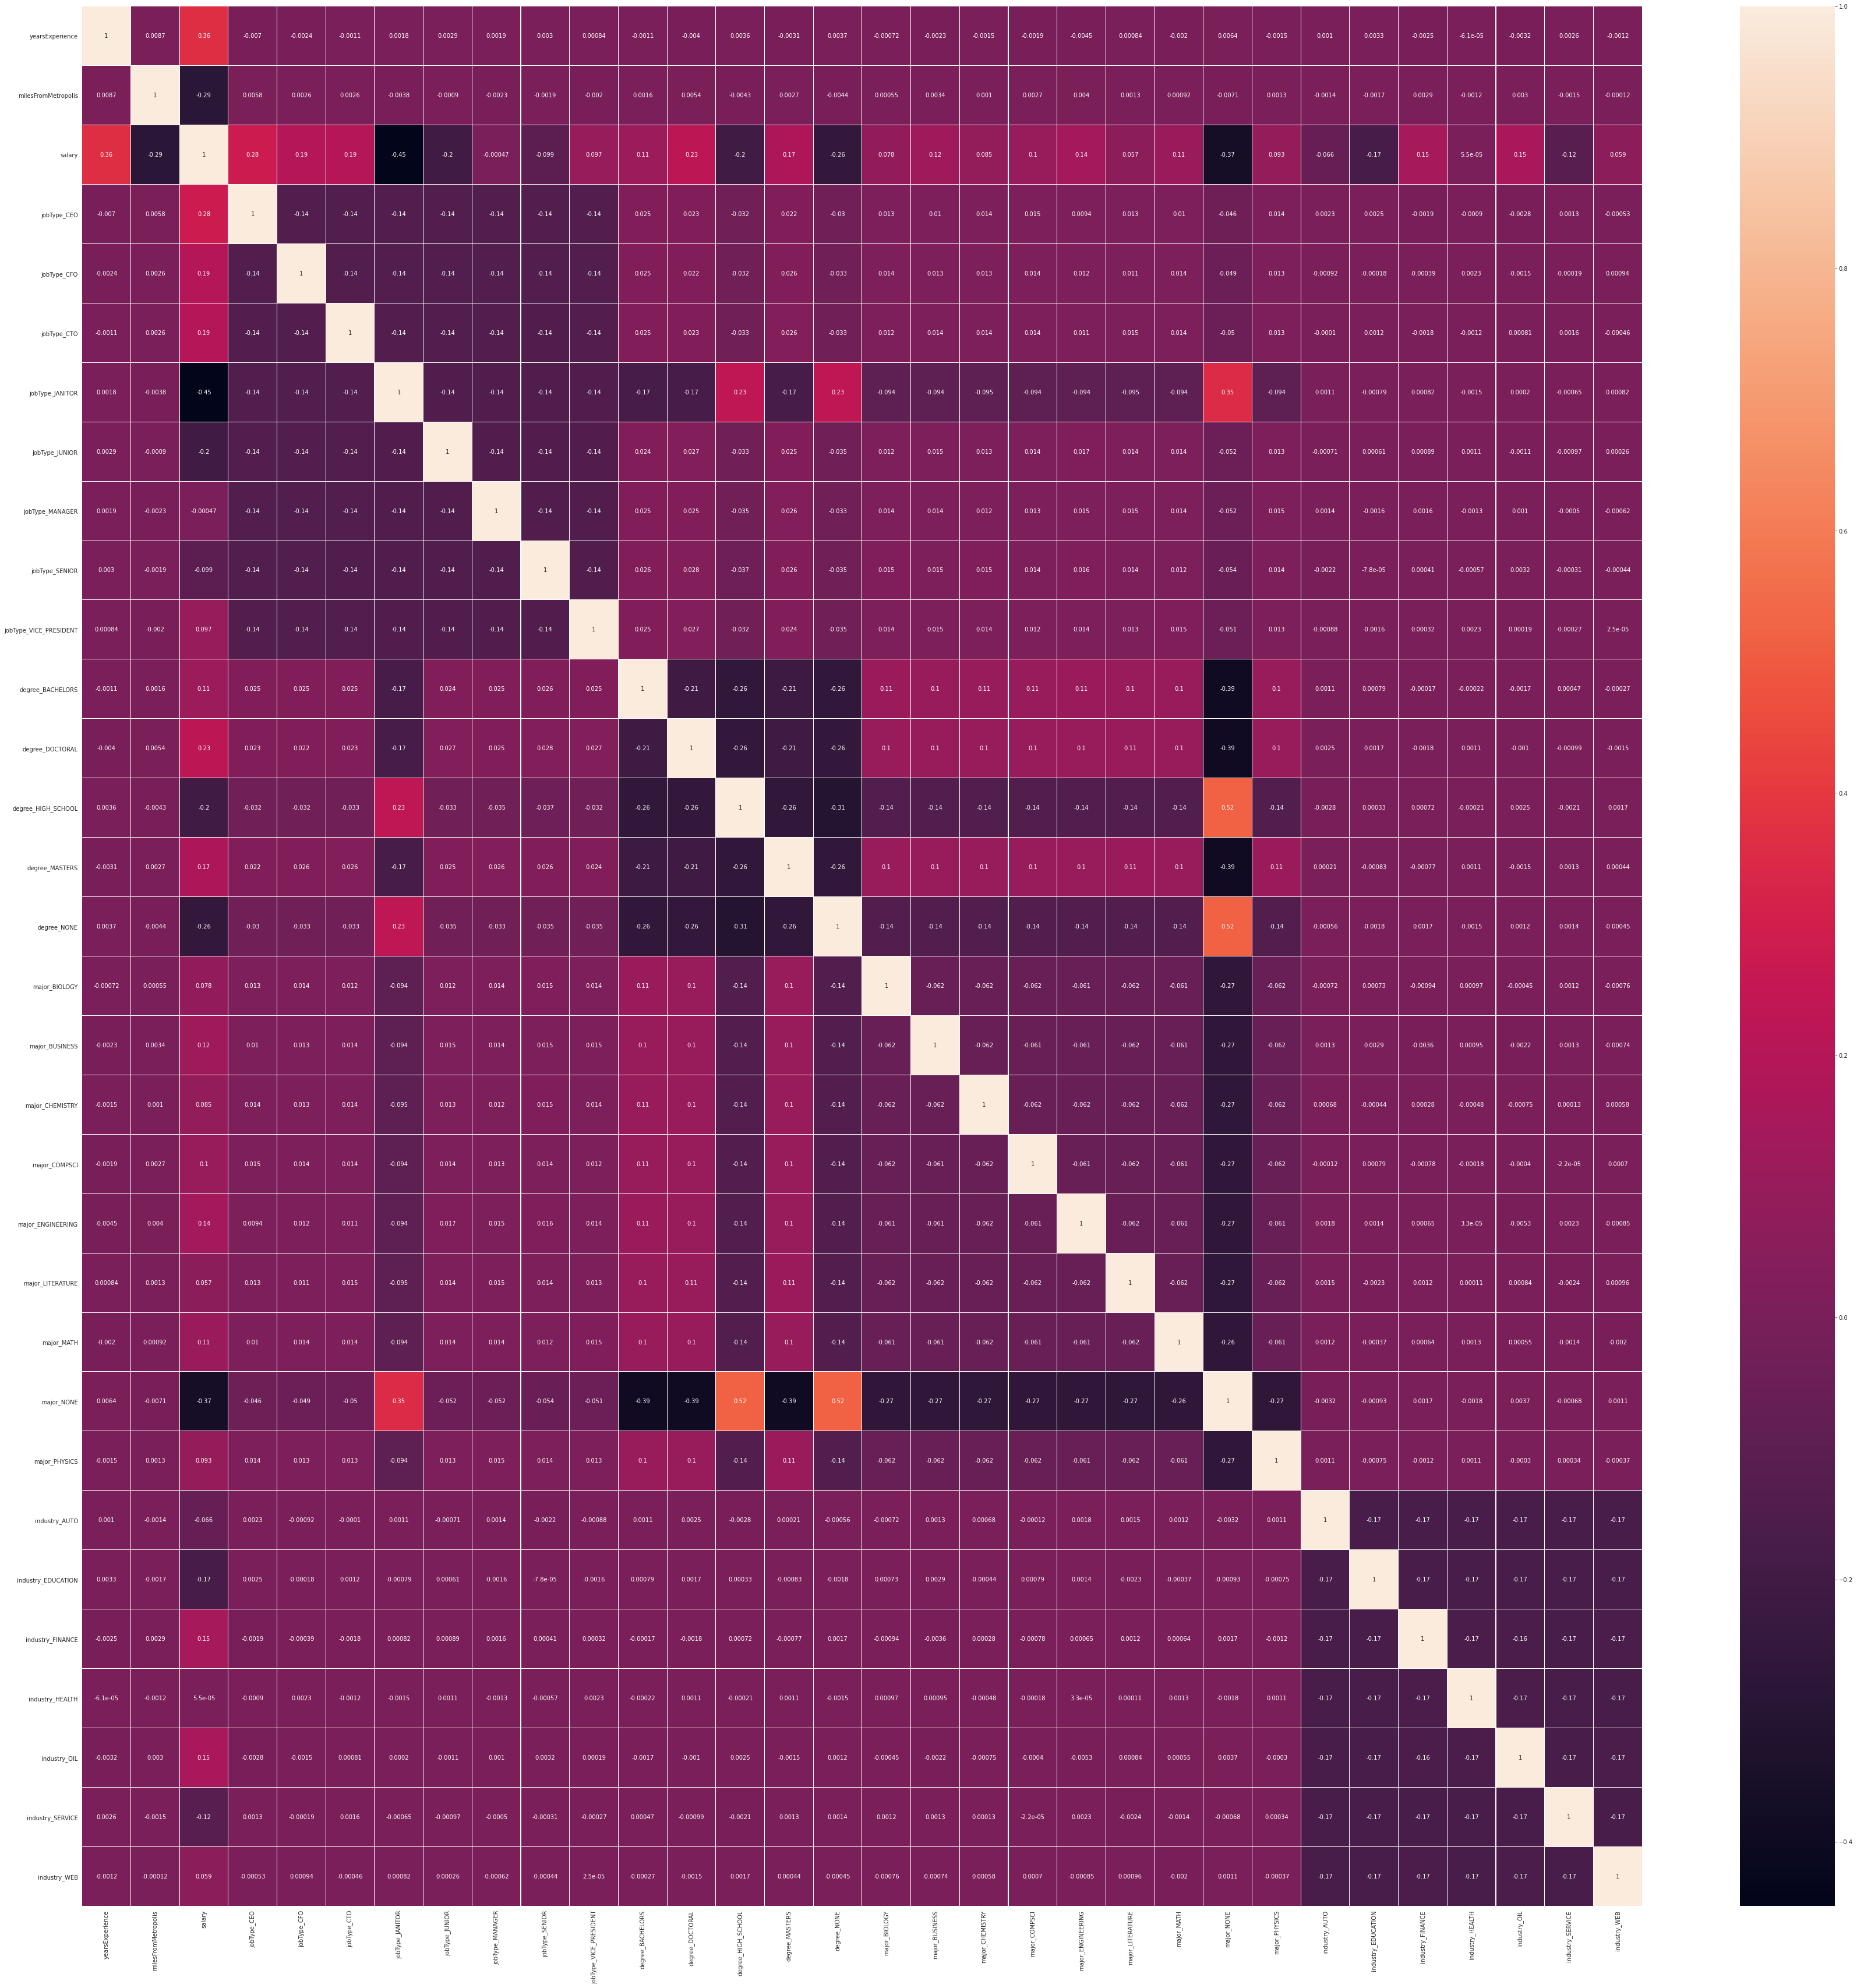

In [ ]:
#CREATE DATASET WITH one hot encoded LABELS
train_data_encoded = pd.get_dummies(train_data_o_IQR)
train_data_encoded.head()

#find correlation between all the varibles
corr = train_data_encoded.corr()

# we can create a heatmap to see the correlation between features
plt.subplots(figsize=(60, 60))

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidth =.005, annot = True)


In [ ]:
corr_df = corr['salary'].abs().sort_values()
corr_cols = corr_df.index
corr_values = corr_df.values


In [ ]:

from collections import defaultdict
corr_avg = defaultdict(list)
for col in columns:
    for i in range(len(corr_cols)):
      name = corr_cols[i]
      val = corr_values[i]
      if col in name:
        corr_avg[col].append(val)

corr_with_salary = {}
for key, value in corr_avg.items():
  corr_with_salary[key] = sum(value) / len(value)

In [ ]:
columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

In [ ]:
#Industry has low correlation with salary.

Prepare data for training

1. Split data into training and testing.

In [ ]:
columns = train_data_encoded.columns.tolist()
features = columns.copy()
features.remove('salary')
X, y = train_data_encoded[features].values, train_data_encoded['salary'].values
poly = PolynomialFeatures(2)
poly.fit(X)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [ ]:

def print_shape(x, shape):
  print("{} shape is {}".format(x, shape))

#split into train and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train_poly, X_test_poly = poly.transform(X_train), poly.transform(X_test)
print_shape('X_train', X_train.shape)
print_shape('y_train', y_train.shape)
print('--------------------------------------')
print_shape('X_test', X_test.shape)
print_shape('y_test', y_test.shape)


X_train shape is (695014, 31)
y_train shape is (695014,)
--------------------------------------
X_test shape is (297864, 31)
y_test shape is (297864,)


In [ ]:
# function for calculation r2-score
def r2_score(ytrue, yhat):
  score = metrics.r2_score(ytrue, yhat)
  return score

Linear regression


19.13581236380233
r2 score of test is  0.7397694696606525


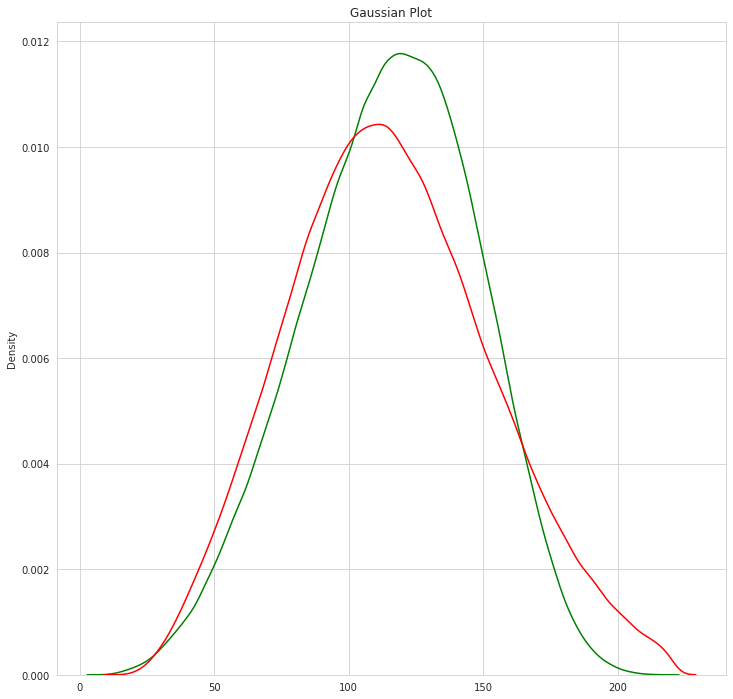

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
yhat = regr.predict(X_test)
mse = metrics.mean_squared_error(y_test, yhat) ** 0.5
print(mse)
r2 = r2_score(y_test, yhat)
print('r2 score of test is ', r2)
gaussianPlot(yhat, y_test, title='Gaussian Plot')
plt.show()

Linear regression with Polynomial features

18.44415439412784
r2 score of test is  0.7582413971955491


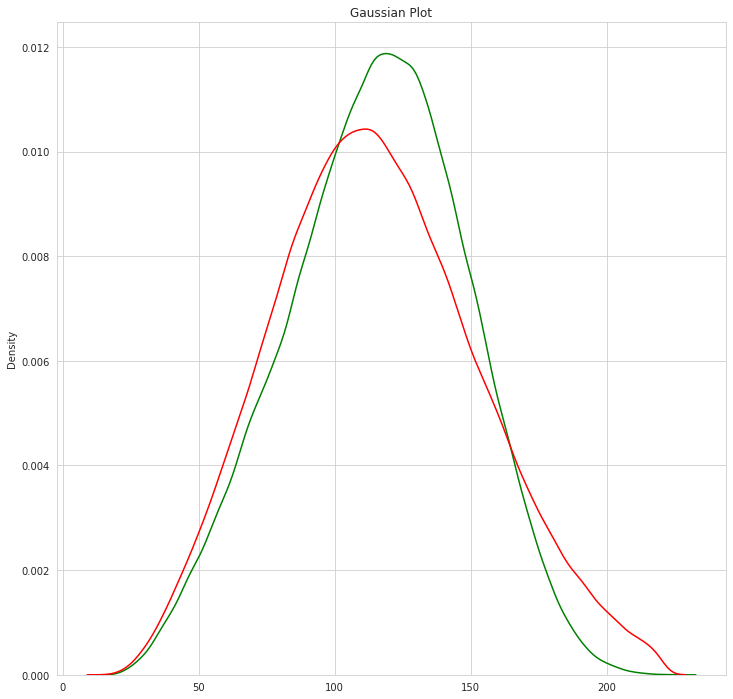

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train_poly, y_train)
yhat = regr.predict(X_test_poly)
mse = metrics.mean_squared_error(y_test, yhat) ** 0.5
print(mse)
r2 = r2_score(y_test, yhat)
print('r2 score of test is ', r2)
gaussianPlot(yhat, y_test, title='Gaussian Plot')
plt.show()

The above model is the model used to predict the test salaries. So, I am saving the model in pickle format and loading the model in a different python notebook for prediction


In [ ]:
#save the co-efficients for testing on the test data
import pickle
filename = 'coefs.pkl'
with open(filename, 'wb') as f:
  pickle.dump(regr, f)


Cross validation with Linear regression.

In [ ]:
from sklearn.model_selection import cross_val_score
clf = linear_model.Ridge()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

clf = linear_model.Ridge()
scores = cross_val_score(clf, X_train_poly, y_train, cv=5)
print(scores)

[0.73858028 0.73888097 0.73932795 0.73692957 0.73891417]
[0.75762693 0.7570236  0.75863265 0.75616143 0.75750062]


Bagging

366.1816936891597
r2 score of test is  0.7397677790853842


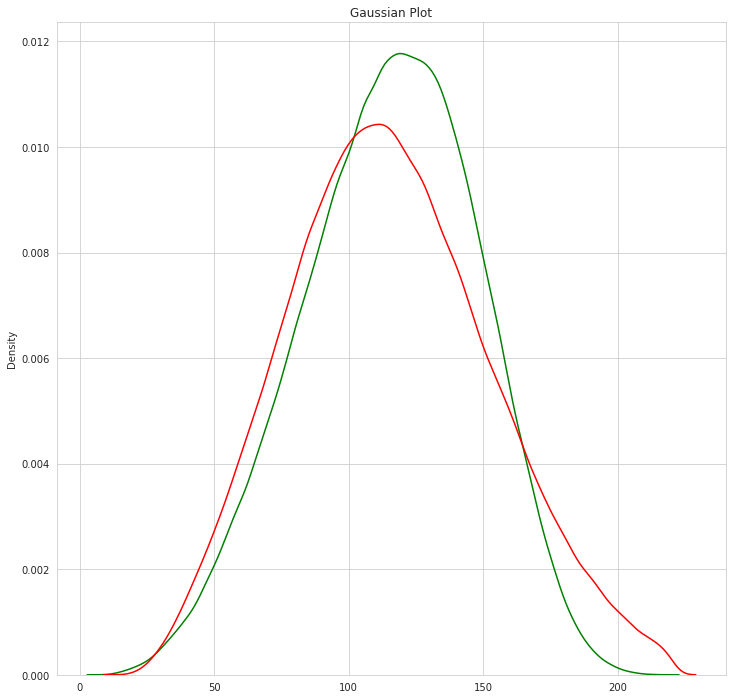

In [ ]:
from sklearn.ensemble import BaggingRegressor
regr = BaggingRegressor(base_estimator=linear_model.LinearRegression(), n_estimators=10, random_state=0).fit(X_train, y_train)
yhat = regr.predict(X_test) 
mse = metrics.mean_squared_error(y_test, yhat) ** 0.5
print(mse)
r2 = r2_score(y_test, yhat)
print('r2 score of test is ', r2)
gaussianPlot(yhat, y_test, title='Gaussian Plot')
plt.show()

Ridge regression

366.1792917301221
0.7397694860716855


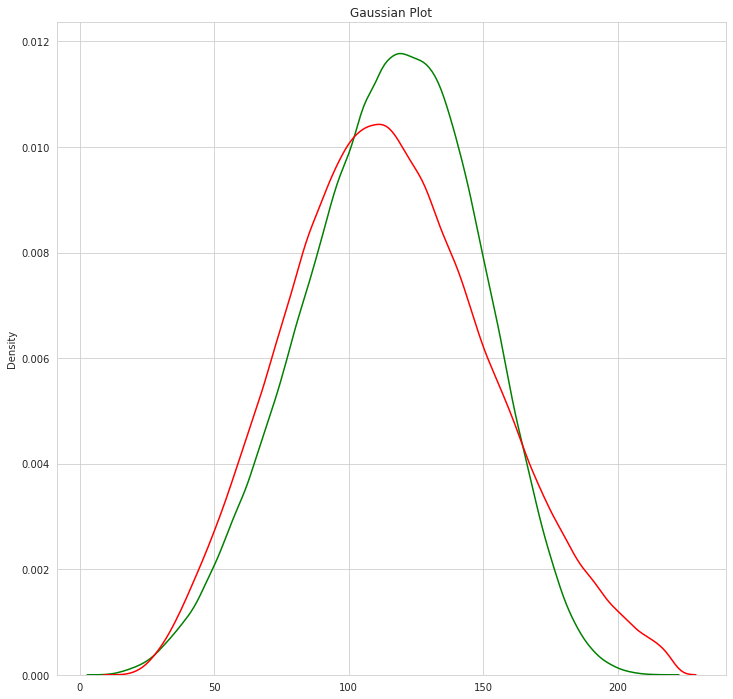

In [ ]:
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
yhat = regr.predict(X_test)
mse = metrics.mean_squared_error(y_test, yhat) ** 0.5
print(mse)
r2 = r2_score(y_test, yhat)
print(r2)
gaussianPlot(yhat, y_test, title='Gaussian Plot')
plt.show()

Ridge regression with polynomial variables


18.44414863625226
0.7582415481393883


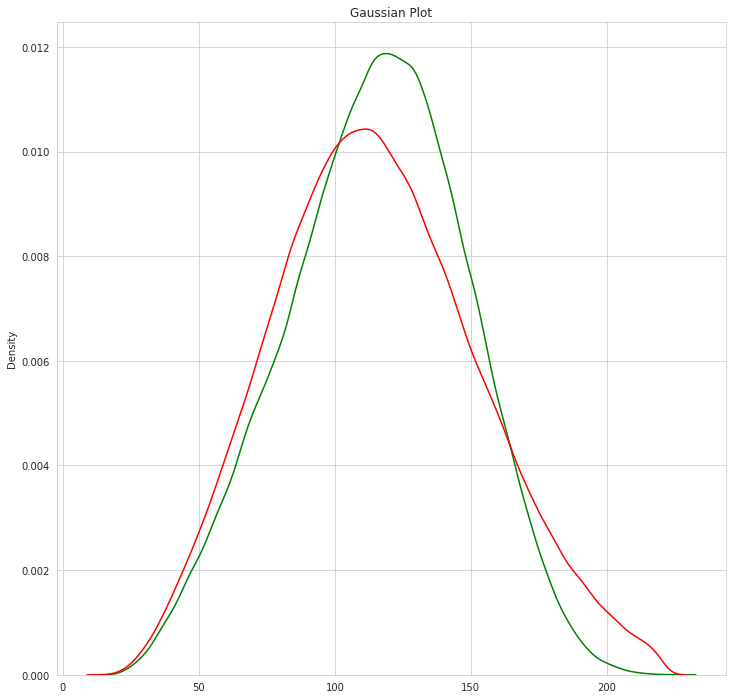

In [ ]:
regr = linear_model.Ridge()
regr.fit(X_train_poly, y_train)
yhat = regr.predict(X_test_poly)
mse = metrics.mean_squared_error(y_test, yhat) ** 0.5
print(mse)
r2 = r2_score(y_test, yhat)
print(r2)
gaussianPlot(yhat, y_test, title='Gaussian Plot')
plt.show()

Decision Tree

674.2247058582349
0.5208526378439596


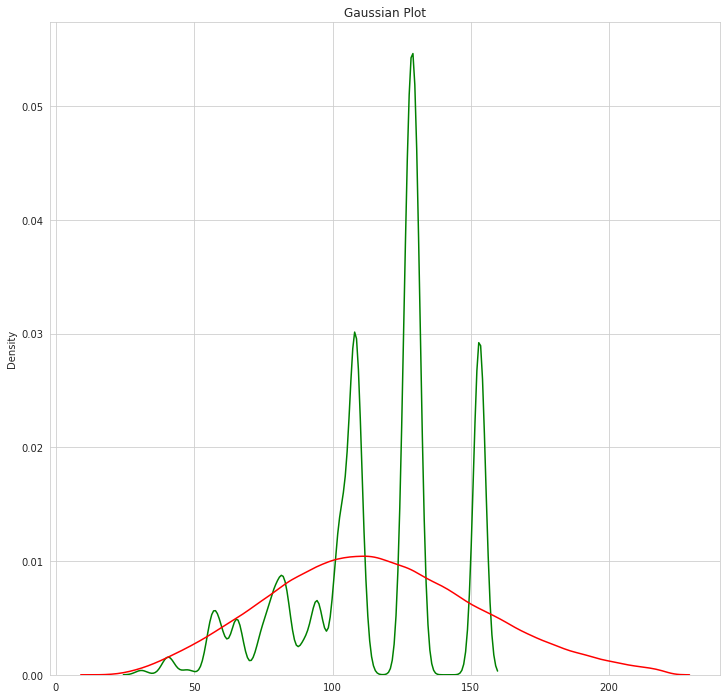

In [ ]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(max_depth=5)
regr.fit(X_train, y_train)
yhat = regr.predict(X_test)

mse = metrics.mean_squared_error(y_test, yhat) ** 0.5
print(mse)

r2 = r2_score(y_test, yhat)
print(r2)
gaussianPlot(yhat, y_test, title='Gaussian Plot')
plt.show()


Decision Tree Regression with Polynomial Features


669.3717016993879
0.5243014941689201


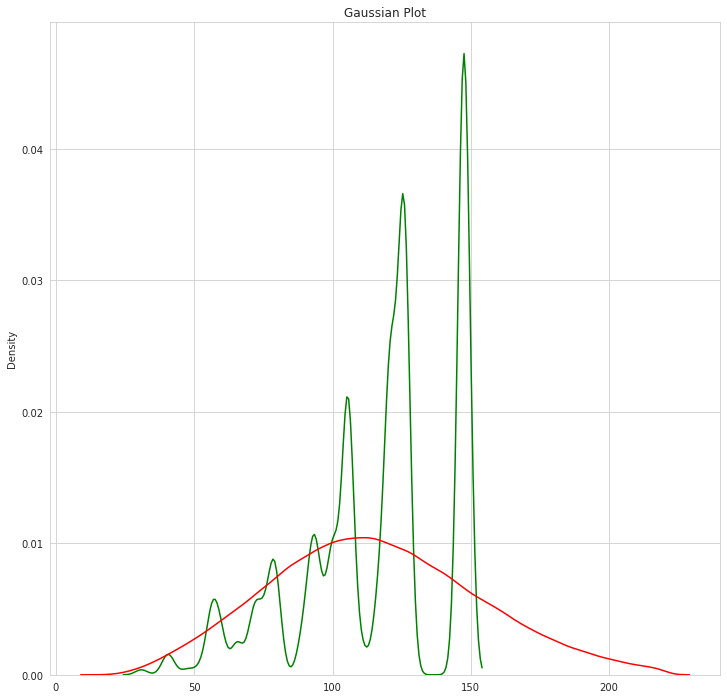

In [ ]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(max_depth=5)
regr.fit(X_train_poly, y_train)
yhat = regr.predict(X_test_poly)

mse = metrics.mean_squared_error(y_test, yhat) ** 0.5
print(mse)

r2 = r2_score(y_test, yhat)
print(r2)
gaussianPlot(yhat, y_test, title='Gaussian Plot')
plt.show()


Gradient Boosting for Regression

In [36]:
# from sklearn.ensemble import GradientBoostingRegressor
# regr = GradientBoostingRegressor(random_state=0, loss='huber')
# regr.fit(X_train, y_train)
# yhat = regr.predict(X_test)
# mse = metrics.mean_squared_error(y_test, yhat)
# print(mse)
# r2 = r2_score(y_test, yhat)
# print(r2)
# gaussianPlot(yhat, y_test, title='Gaussian Plot')
# plt.show()

KeyboardInterrupt: ignored

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# regr = GradientBoostingRegressor(random_state=0, loss='huber')
# regr.fit(X_train_poly, y_train)
# yhat = regr.predict(X_test_poly)
# mse = metrics.mean_squared_error(y_test, yhat)
# print(mse)
# r2 = r2_score(y_test, yhat)
# print(r2)
# gaussianPlot(yhat, y_test, title='Gaussian Plot')
# plt.show()

In [ ]:
# from sklearn.ensemble import VotingRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression, Ridge
# reg1 = GradientBoostingRegressor(random_state=0, loss='huber')
# # reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
# reg2 = Ridge()
# reg3 = LinearRegression()
# regr = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
# regr.fit(X_train_poly, y_train)
# yhat = regr.predict(X_test_poly)

# mse = metrics.mean_squared_error(y_test, yhat)
# print(mse)

# r2 = r2_score(y_test, yhat)
# print(r2)
# gaussianPlot(yhat, y_test, title='Gaussian Plot')
# plt.show()

Ada Boost regression







In [ ]:
# from sklearn.ensemble import AdaBoostRegressor
# regr = AdaBoostRegressor(n_estimators=100)
# regr.fit(X_train, y_train)
# yhat = regr.predict(X_test)
# mse = metrics.mean_squared_error(y_test, yhat)
# print(mse)
# r2 = r2_score(y_test, yhat)
# print(r2)
# gaussianPlot(yhat, y_test, title='Gaussian Plot')
# plt.show()

Support Vector Machine

In [ ]:
# from sklearn.svm import SVR
# regr = SVR()
# regr.fit(X_train, y_train)
# yhat = regr.predict(X_test)
# mse = metrics.mean_squared_error(y_test, yhat)
# print(mse)
# r2 = r2_score(y_test, yhat)
# print(r2)

PCA for feature selection

A small Neural Network

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# def build_and_compile_model(norm):
#   model = keras.Sequential([
#       norm,
#       layers.Dense(64, activation='relu'),
#       keras.layers.Dropout(0.2),
#       layers.Dense(128, activation='relu'),
#       keras.layers.Dropout(0.2),
#       layers.Dense(1)
#   ])
#   model.compile(loss='mean_squared_error',
#                 optimizer=tf.keras.optimizers.Adam(0.001))
#   return model
# normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
# model = build_and_compile_model(normalizer)
# history = model.fit(X_train_poly, y_train, epochs=50, batch_size = 8, validation_data=(X_test_poly, y_test))

'''
Epoch 1/50
75000/75000 [==============================] - 195s 3ms/step - loss: 579.1052 - val_loss: 630.4641
Epoch 2/50
75000/75000 [==============================] - 195s 3ms/step - loss: 476.6533 - val_loss: 536.5850
Epoch 3/50
75000/75000 [==============================] - 196s 3ms/step - loss: 461.7621 - val_loss: 457.6929
Epoch 4/50
75000/75000 [==============================] - 194s 3ms/step - loss: 455.8203 - val_loss: 459.3316
Epoch 5/50
75000/75000 [==============================] - 195s 3ms/step - loss: 448.5616 - val_loss: 434.6849
Epoch 6/50
75000/75000 [==============================] - 195s 3ms/step - loss: 443.7943 - val_loss: 580.8617
Epoch 7/50
75000/75000 [==============================] - 194s 3ms/step - loss: 440.4556 - val_loss: 425.0079
Epoch 8/50
75000/75000 [==============================] - 196s 3ms/step - loss: 435.9480 - val_loss: 391.9290
Epoch 9/50
75000/75000 [==============================] - 195s 3ms/step - loss: 433.6452 - val_loss: 414.9470
Epoch 10/50
75000/75000 [==============================] - 196s 3ms/step - loss: 432.6768 - val_loss: 382.6801
Epoch 11/50
75000/75000 [==============================] - 196s 3ms/step - loss: 430.5243 - val_loss: 437.2612
Epoch 12/50
75000/75000 [==============================] - 195s 3ms/step - loss: 428.4731 - val_loss: 371.4792
Epoch 13/50
75000/75000 [==============================] - 197s 3ms/step - loss: 426.6373 - val_loss: 401.6620
Epoch 14/50
75000/75000 [==============================] - 197s 3ms/step - loss: 423.4474 - val_loss: 377.5172
Epoch 15/50
75000/75000 [==============================] - 196s 3ms/step - loss: 422.5759 - val_loss: 381.5662
Epoch 16/50
75000/75000 [==============================] - 197s 3ms/step - loss: 421.9205 - val_loss: 382.6263
Epoch 17/50
75000/75000 [==============================] - 197s 3ms/step - loss: 418.8957 - val_loss: 369.0948
Epoch 18/50
75000/75000 [==============================] - 196s 3ms/step - loss: 419.5226 - val_loss: 456.3504
Epoch 19/50
75000/75000 [==============================] - 196s 3ms/step - loss: 418.5419 - val_loss: 369.7481
Epoch 20/50
75000/75000 [==============================] - 195s 3ms/step - loss: 418.9074 - val_loss: 374.4550
Epoch 21/50
75000/75000 [==============================] - 194s 3ms/step - loss: 417.2874 - val_loss: 383.4771
Epoch 22/50
75000/75000 [==============================] - 193s 3ms/step - loss: 414.8195 - val_loss: 395.4201
Epoch 23/50
75000/75000 [==============================] - 190s 3ms/step - loss: 413.8874 - val_loss: 378.5687
Epoch 24/50
75000/75000 [==============================] - 189s 3ms/step - loss: 413.4799 - val_loss: 380.1624
Epoch 25/50
75000/75000 [==============================] - 189s 3ms/step - loss: 411.4049 - val_loss: 395.5688
Epoch 26/50
75000/75000 [==============================] - 189s 3ms/step - loss: 411.9154 - val_loss: 372.2394
Epoch 27/50
75000/75000 [==============================] - 191s 3ms/step - loss: 410.7525 - val_loss: 405.0017
Epoch 28/50
75000/75000 [==============================] - 194s 3ms/step - loss: 410.1906 - val_loss: 419.8918
Epoch 29/50
75000/75000 [==============================] - 203s 3ms/step - loss: 410.3177 - val_loss: 392.3708
Epoch 30/50
75000/75000 [==============================] - 193s 3ms/step - loss: 409.5353 - val_loss: 377.7834
Epoch 31/50
75000/75000 [==============================] - 191s 3ms/step - loss: 409.4410 - val_loss: 399.7426
Epoch 32/50
75000/75000 [==============================] - 192s 3ms/step - loss: 408.2900 - val_loss: 461.4396
Epoch 33/50
75000/75000 [==============================] - 191s 3ms/step - loss: 408.3232 - val_loss: 398.5940
Epoch 34/50
75000/75000 [==============================] - 191s 3ms/step - loss: 408.5226 - val_loss: 403.9028
Epoch 35/50
75000/75000 [==============================] - 189s 3ms/step - loss: 403.7647 - val_loss: 374.6355
Epoch 36/50
75000/75000 [==============================] - 189s 3ms/step - loss: 405.7481 - val_loss: 394.7280
Epoch 37/50
75000/75000 [==============================] - 189s 3ms/step - loss: 401.8880 - val_loss: 402.8705
Epoch 38/50
75000/75000 [==============================] - 190s 3ms/step - loss: 401.3353 - val_loss: 408.0948
Epoch 39/50
75000/75000 [==============================] - 191s 3ms/step - loss: 402.0963 - val_loss: 387.7498
Epoch 40/50
75000/75000 [==============================] - 190s 3ms/step - loss: 400.2551 - val_loss: 399.7443
Epoch 41/50
75000/75000 [==============================] - 189s 3ms/step - loss: 400.7018 - val_loss: 411.8970
Epoch 42/50
75000/75000 [==============================] - 189s 3ms/step - loss: 399.0709 - val_loss: 393.1291
Epoch 43/50
75000/75000 [==============================] - 189s 3ms/step - loss: 399.4236 - val_loss: 390.5453
Epoch 44/50
75000/75000 [==============================] - 190s 3ms/step - loss: 399.0800 - val_loss: 432.5241
Epoch 45/50
75000/75000 [==============================] - 190s 3ms/step - loss: 399.1641 - val_loss: 388.8550
Epoch 46/50
75000/75000 [==============================] - 189s 3ms/step - loss: 398.3857 - val_loss: 396.2421
Epoch 47/50
75000/75000 [==============================] - 190s 3ms/step - loss: 398.1049 - val_loss: 401.6029
Epoch 48/50
75000/75000 [==============================] - 189s 3ms/step - loss: 398.4248 - val_loss: 423.7469
Epoch 49/50
75000/75000 [==============================] - 188s 3ms/step - loss: 398.0718 - val_loss: 390.8672
Epoch 50/50
75000/75000 [==============================] - 189s 3ms/step - loss: 398.2257 - val_loss: 399.0513
'''

All the code that are commented are working code of different algorithms. It take